# Coconut Mite Detection - Data Exploration

This notebook explores the coconut mite dataset for training a pest detection model.

## Dataset Info
- **Source:** Drone images of coconut trees
- **Task:** Binary classification (mite infected vs healthy)
- **Project:** SLIIT Research - Coconut Health Monitor

## 1. Setup & Imports

In [18]:
# Install dependencies if needed
# !pip install tensorflow opencv-python matplotlib seaborn pillow

In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
import random
from collections import Counter

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [20]:
# Define paths
BASE_PATH = Path('../data/raw/pest')
MITE_PATH = BASE_PATH / 'coconut_mite'
HEALTHY_PATH = BASE_PATH / 'healthy'

print(f"Mite images path: {MITE_PATH}")
print(f"Healthy images path: {HEALTHY_PATH}")
print(f"\nMite path exists: {MITE_PATH.exists()}")
print(f"Healthy path exists: {HEALTHY_PATH.exists()}")

Mite images path: ..\data\raw\pest\coconut_mite
Healthy images path: ..\data\raw\pest\healthy

Mite path exists: True
Healthy path exists: True


## 2. Dataset Statistics

In [21]:
def count_images(folder_path):
    """Count images in a folder"""
    if not folder_path.exists():
        return 0
    extensions = ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG']
    count = sum(1 for f in folder_path.iterdir() if f.suffix in extensions)
    return count

def get_folder_size(folder_path):
    """Get total size of folder in MB"""
    if not folder_path.exists():
        return 0
    total_size = sum(f.stat().st_size for f in folder_path.iterdir() if f.is_file())
    return total_size / (1024 * 1024)  # Convert to MB

# Count images
mite_count = count_images(MITE_PATH)
healthy_count = count_images(HEALTHY_PATH)

print("=" * 50)
print("DATASET STATISTICS")
print("=" * 50)
print(f"\nCoconut Mite Images: {mite_count:,}")
print(f"Healthy Images: {healthy_count:,}")
print(f"Total Images: {mite_count + healthy_count:,}")
print(f"\nMite folder size: {get_folder_size(MITE_PATH):.2f} MB")
print(f"Healthy folder size: {get_folder_size(HEALTHY_PATH):.2f} MB")

DATASET STATISTICS

Coconut Mite Images: 4,747
Healthy Images: 4,228
Total Images: 8,975

Mite folder size: 12069.74 MB
Healthy folder size: 310.13 MB


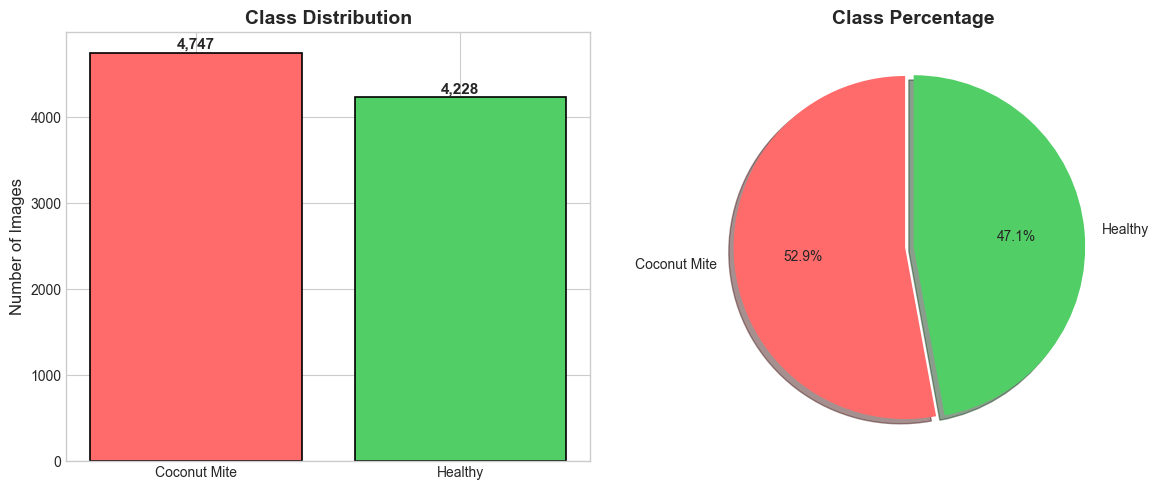

In [22]:
# Visualize class distribution
classes = ['Coconut Mite', 'Healthy']
counts = [mite_count, healthy_count]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart
colors = ['#ff6b6b', '#51cf66']
axes[0].bar(classes, counts, color=colors, edgecolor='black', linewidth=1.2)
axes[0].set_ylabel('Number of Images', fontsize=12)
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
for i, v in enumerate(counts):
    axes[0].text(i, v + 50, f'{v:,}', ha='center', fontsize=11, fontweight='bold')

# Pie chart
if sum(counts) > 0:
    axes[1].pie(counts, labels=classes, autopct='%1.1f%%', colors=colors,
                explode=(0.05, 0), shadow=True, startangle=90)
    axes[1].set_title('Class Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../models/coconut_mite/class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Sample Images Visualization

In [23]:
def load_sample_images(folder_path, n_samples=6):
    """Load random sample images from a folder"""
    if not folder_path.exists():
        return []
    
    extensions = ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG']
    image_files = [f for f in folder_path.iterdir() if f.suffix in extensions]
    
    if len(image_files) == 0:
        return []
    
    samples = random.sample(image_files, min(n_samples, len(image_files)))
    return samples

def display_images(image_paths, title, n_cols=3):
    """Display images in a grid"""
    n_images = len(image_paths)
    if n_images == 0:
        print(f"No images found for {title}")
        return
    
    n_rows = (n_images + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten() if n_images > 1 else [axes]
    
    fig.suptitle(title, fontsize=16, fontweight='bold', y=1.02)
    
    for idx, img_path in enumerate(image_paths):
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].set_title(f'{img_path.name}\n{img.size[0]}x{img.size[1]}', fontsize=9)
        axes[idx].axis('off')
    
    # Hide empty subplots
    for idx in range(n_images, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

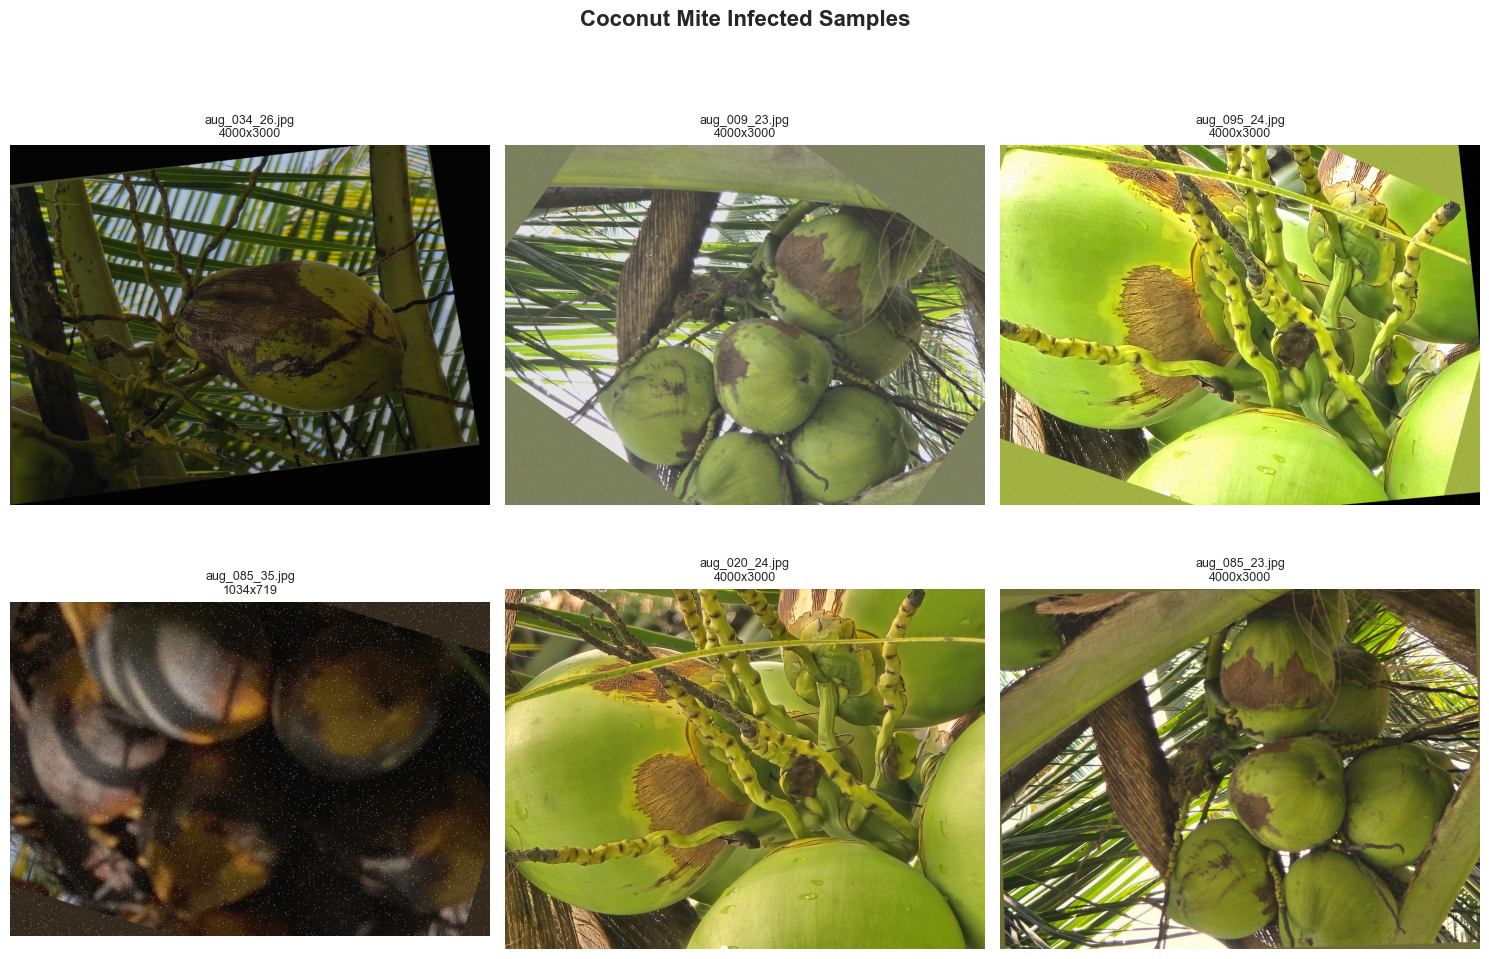

In [24]:
# Display coconut mite infected samples
mite_samples = load_sample_images(MITE_PATH, n_samples=6)
display_images(mite_samples, 'Coconut Mite Infected Samples')

In [25]:
# Display healthy samples (if available)
healthy_samples = load_sample_images(HEALTHY_PATH, n_samples=6)
if healthy_samples:
    display_images(healthy_samples, 'Healthy Coconut Tree Samples')
else:
    print("⚠️ No healthy images found! Please upload healthy images to:")
    print(f"   {HEALTHY_PATH.absolute()}")

## 4. Image Properties Analysis

In [26]:
def analyze_images(folder_path, sample_size=100):
    """Analyze image properties"""
    if not folder_path.exists():
        return None
    
    extensions = ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG']
    image_files = [f for f in folder_path.iterdir() if f.suffix in extensions]
    
    if len(image_files) == 0:
        return None
    
    # Sample images for analysis
    samples = random.sample(image_files, min(sample_size, len(image_files)))
    
    widths = []
    heights = []
    file_sizes = []
    
    for img_path in samples:
        img = Image.open(img_path)
        widths.append(img.size[0])
        heights.append(img.size[1])
        file_sizes.append(img_path.stat().st_size / 1024)  # KB
    
    return {
        'widths': widths,
        'heights': heights,
        'file_sizes': file_sizes
    }

# Analyze mite images
mite_analysis = analyze_images(MITE_PATH)

if mite_analysis:
    print("=" * 50)
    print("COCONUT MITE IMAGE ANALYSIS")
    print("=" * 50)
    print(f"\nWidth  - Min: {min(mite_analysis['widths'])}, Max: {max(mite_analysis['widths'])}, Avg: {np.mean(mite_analysis['widths']):.0f}")
    print(f"Height - Min: {min(mite_analysis['heights'])}, Max: {max(mite_analysis['heights'])}, Avg: {np.mean(mite_analysis['heights']):.0f}")
    print(f"File Size - Min: {min(mite_analysis['file_sizes']):.0f}KB, Max: {max(mite_analysis['file_sizes']):.0f}KB, Avg: {np.mean(mite_analysis['file_sizes']):.0f}KB")

COCONUT MITE IMAGE ANALYSIS

Width  - Min: 340, Max: 4080, Avg: 3252
Height - Min: 205, Max: 3060, Avg: 2422
File Size - Min: 16KB, Max: 8571KB, Avg: 2980KB


In [27]:
# Visualize image dimensions distribution
if mite_analysis:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    axes[0].hist(mite_analysis['widths'], bins=20, color='steelblue', edgecolor='black')
    axes[0].set_xlabel('Width (pixels)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Image Width Distribution')
    
    axes[1].hist(mite_analysis['heights'], bins=20, color='coral', edgecolor='black')
    axes[1].set_xlabel('Height (pixels)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Image Height Distribution')
    
    axes[2].hist(mite_analysis['file_sizes'], bins=20, color='mediumseagreen', edgecolor='black')
    axes[2].set_xlabel('File Size (KB)')
    axes[2].set_ylabel('Frequency')
    axes[2].set_title('File Size Distribution')
    
    plt.tight_layout()
    plt.savefig('../models/coconut_mite/image_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

## 5. Data Preprocessing Recommendations

In [28]:
print("=" * 60)
print("PREPROCESSING RECOMMENDATIONS FOR MODEL TRAINING")
print("=" * 60)

print("""
1. IMAGE RESIZING:
   - Current: 4000x3000 pixels (very large)
   - Recommended: 224x224 or 256x256 for CNN models
   - This will reduce training time significantly

2. DATA SPLIT:
   - Training: 70%
   - Validation: 15%
   - Test: 15%

3. AUGMENTATION (Already Applied):
   - Images appear to have rotation augmentation
   - Additional augmentation may not be necessary
   - Consider: brightness, contrast adjustments only

4. NORMALIZATION:
   - Scale pixel values to [0, 1] or [-1, 1]
   - Use ImageNet mean/std if using transfer learning

5. CLASS BALANCE:
   - Ensure healthy images match mite image count
   - Use class weights if imbalanced

6. MODEL RECOMMENDATIONS:
   - Transfer Learning: MobileNetV2, EfficientNetB0, ResNet50
   - MobileNetV2 recommended for mobile deployment
""")

# Check class balance status
if mite_count > 0 and healthy_count > 0:
    ratio = max(mite_count, healthy_count) / min(mite_count, healthy_count)
    if ratio > 2:
        print(f"⚠️ WARNING: Class imbalance detected! Ratio: {ratio:.2f}")
        print("   Consider using class weights or oversampling.")
    else:
        print(f"✅ Classes are relatively balanced. Ratio: {ratio:.2f}")
elif healthy_count == 0:
    print("❌ ERROR: No healthy images found!")
    print("   Please upload healthy coconut tree images before training.")

PREPROCESSING RECOMMENDATIONS FOR MODEL TRAINING

1. IMAGE RESIZING:
   - Current: 4000x3000 pixels (very large)
   - Recommended: 224x224 or 256x256 for CNN models
   - This will reduce training time significantly

2. DATA SPLIT:
   - Training: 70%
   - Validation: 15%
   - Test: 15%

3. AUGMENTATION (Already Applied):
   - Images appear to have rotation augmentation
   - Additional augmentation may not be necessary
   - Consider: brightness, contrast adjustments only

4. NORMALIZATION:
   - Scale pixel values to [0, 1] or [-1, 1]
   - Use ImageNet mean/std if using transfer learning

5. CLASS BALANCE:
   - Ensure healthy images match mite image count
   - Use class weights if imbalanced

6. MODEL RECOMMENDATIONS:
   - Transfer Learning: MobileNetV2, EfficientNetB0, ResNet50
   - MobileNetV2 recommended for mobile deployment

✅ Classes are relatively balanced. Ratio: 1.12


## 6. Next Steps

1. ✅ Data exploration complete
2. ⬜ Upload healthy images (if not done)
3. ⬜ Run `02_coconut_mite_training.ipynb` to train the model
4. ⬜ Evaluate model performance
5. ⬜ Deploy model via Flask API

In [29]:
print("\n" + "=" * 50)
print("DATA EXPLORATION COMPLETE!")
print("=" * 50)
print(f"\n📊 Total Mite Images: {mite_count:,}")
print(f"📊 Total Healthy Images: {healthy_count:,}")
print("\n👉 Next: Run 02_coconut_mite_training.ipynb")


DATA EXPLORATION COMPLETE!

📊 Total Mite Images: 4,747
📊 Total Healthy Images: 4,228

👉 Next: Run 02_coconut_mite_training.ipynb
